In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
%matplotlib inline

In [2]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
train = pd.read_csv('course_project_train.csv')
test = pd.read_csv('course_project_test.csv')

Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [388]:
train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


Посчитаем количество пропусков

In [7]:
len(train) - train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Посмотрим описательную статистику

In [8]:
train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Данные содержат выбросы. Далее посмотрим детально на их распределение.
Поле "количество месяцев с последней просрочки платежа (Months since last delinquent)" содержит более половины пропущенных данныъ, поэтому удалим данный признак из выборки

In [11]:
train = train.drop('Months since last delinquent', axis=1)

Посмотрим на распределение объектных  и числовых данных

In [14]:
df = train.copy()
for colname in ['Tax Liens', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies']:
    df[colname] = df[colname].astype(str)

In [15]:
TARGET_NAME = 'Credit Default'
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')   

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Open Accounts

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313


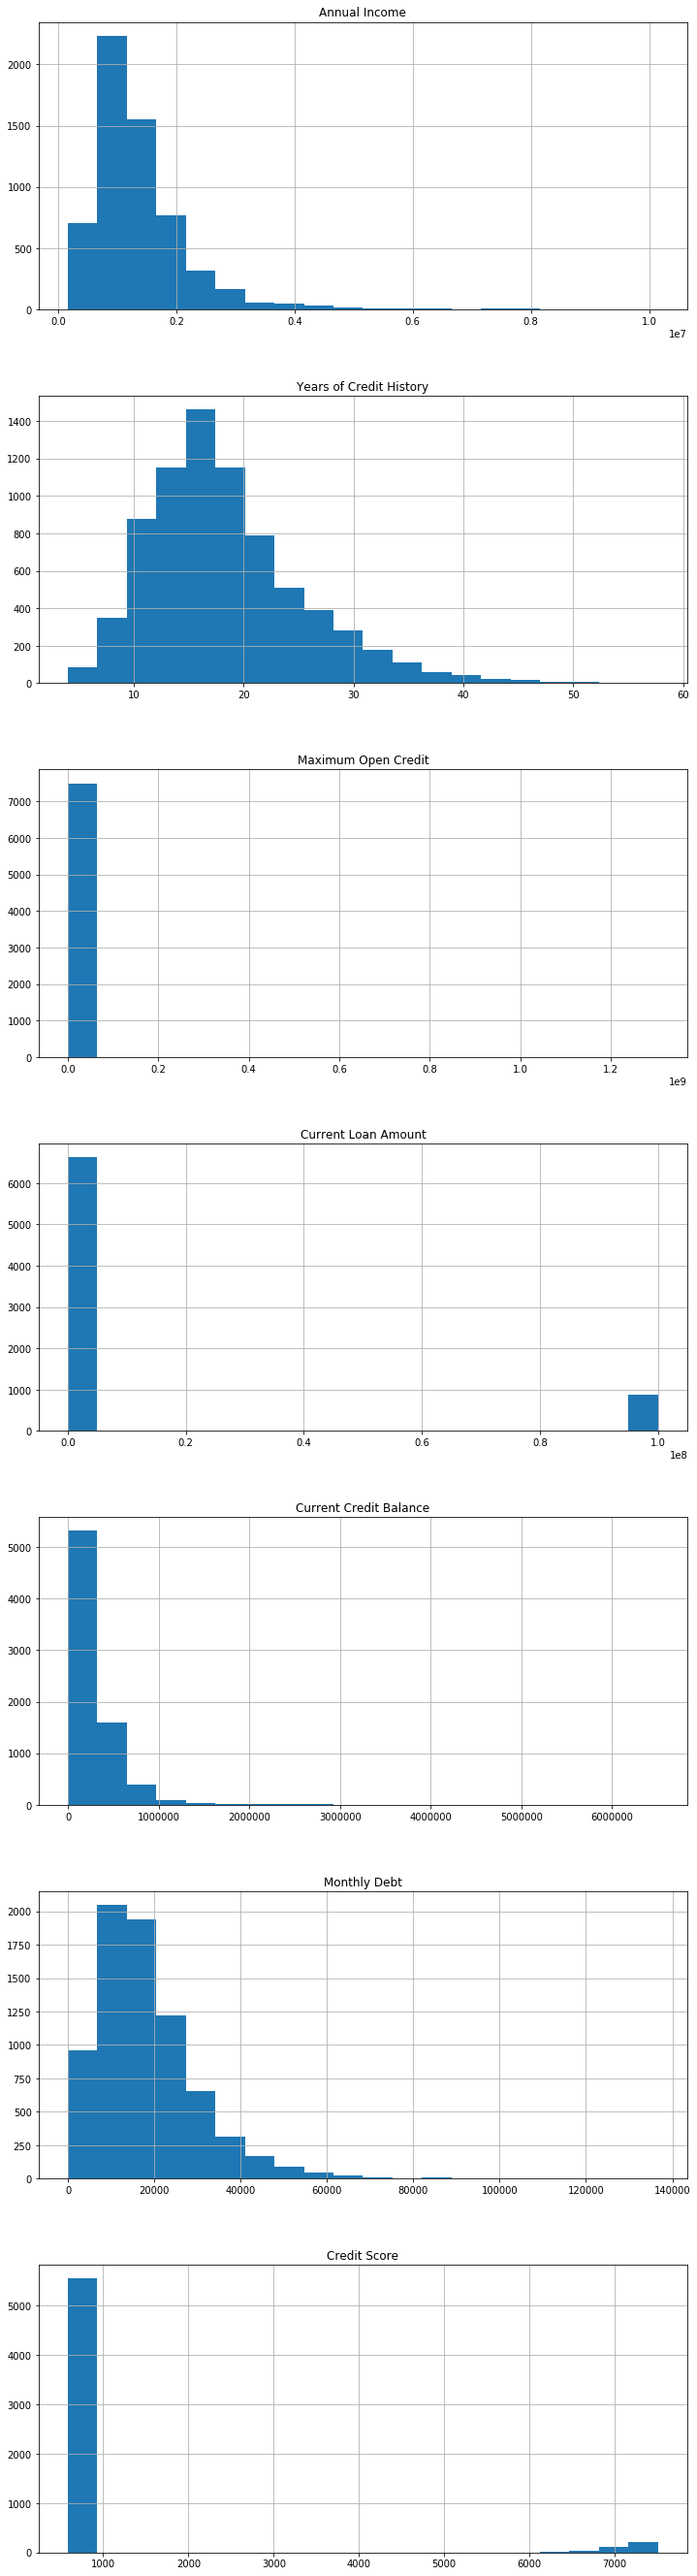

In [16]:
f_cols = df.select_dtypes(include='float').columns

fig, axes = plt.subplots(len(f_cols), 1, figsize=(12, 48))
for col, axis in zip(f_cols, axes):
    df.hist(column = col, bins = 20, ax=axis)

Посмотрим распределение целевой переменной

In [17]:
train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Посомтрим как признаки связаны с целевой переменной

In [18]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

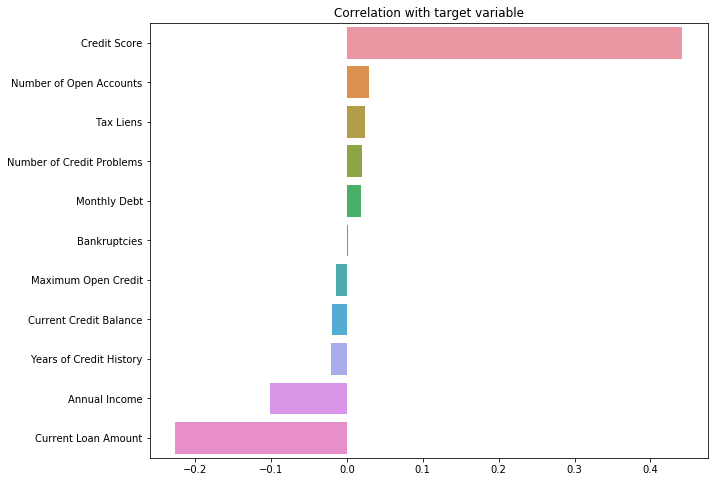

In [19]:
corr_with_target = train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

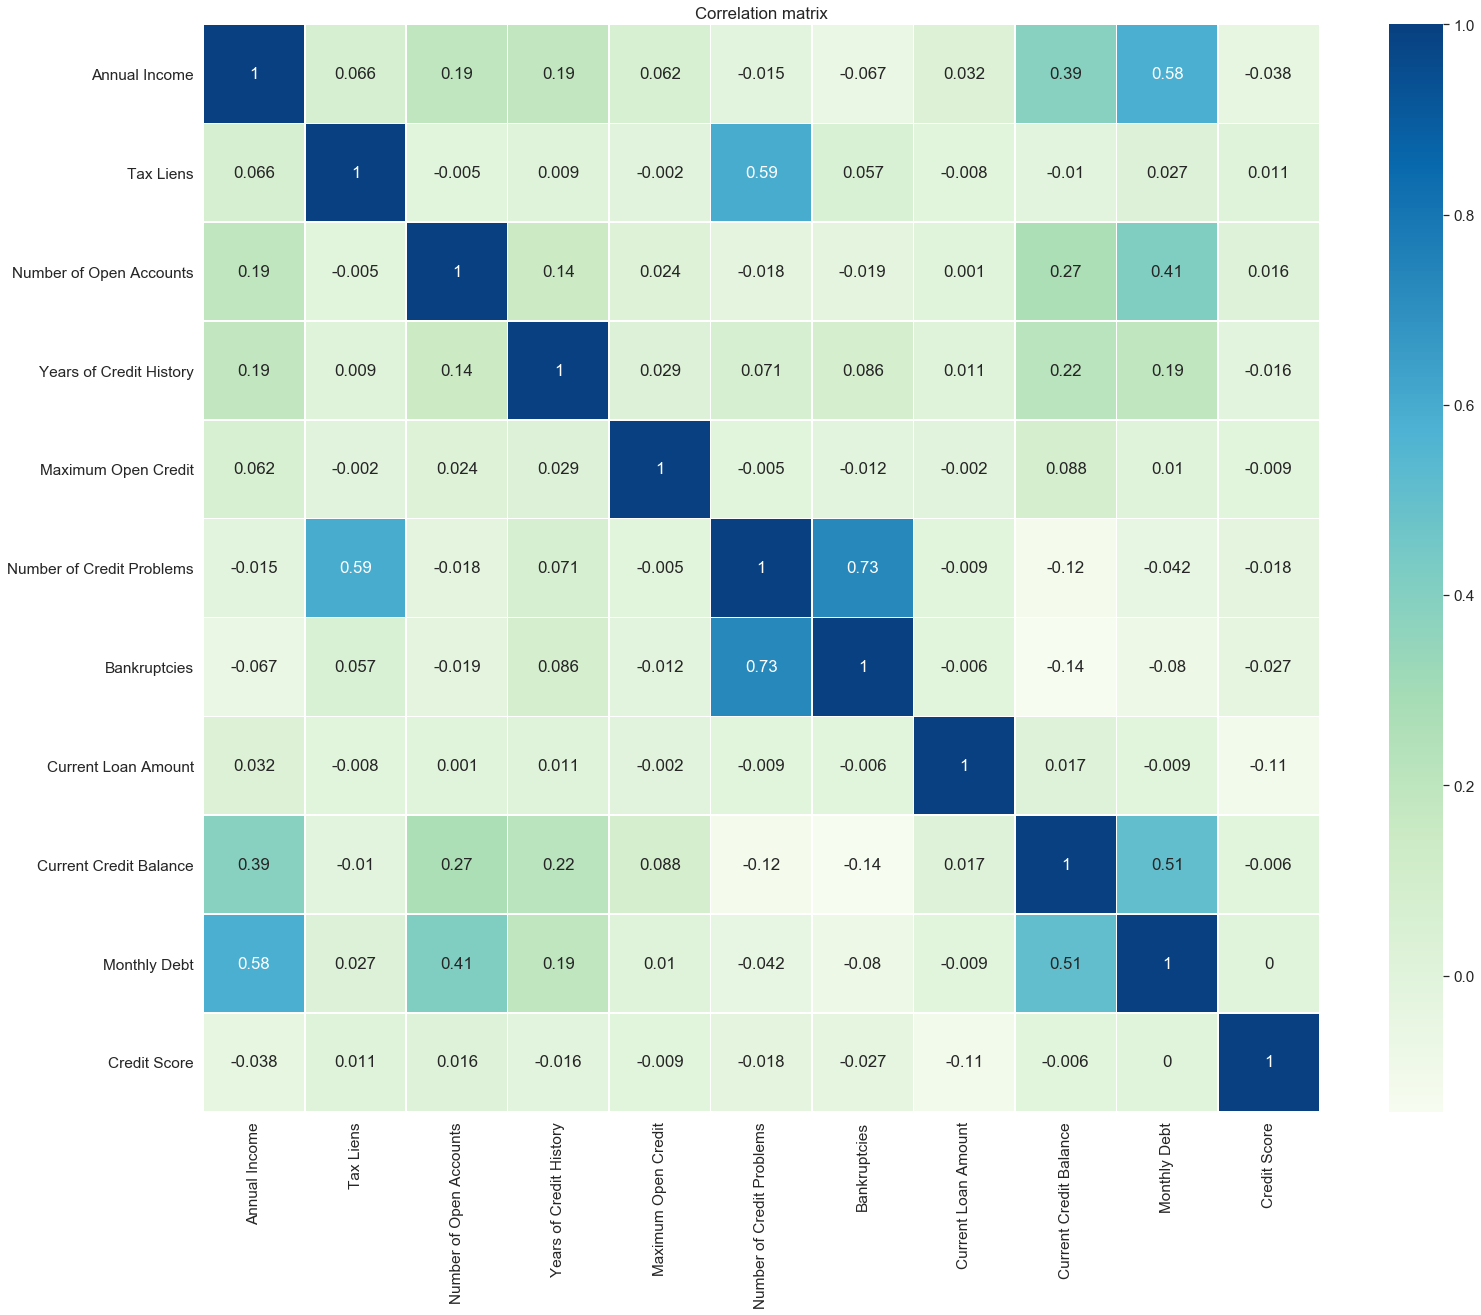

In [20]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

МЫ видим, что существует 2 фактора, оказывающих наибольшее влияние на целевую переменную: текущая сумма кредита и кредитный рейтинг, но при этом сами эти факторы не имеют линейно йсвязи с другими факторами

Рассмотрим детальное распределение кредитного рейтинга

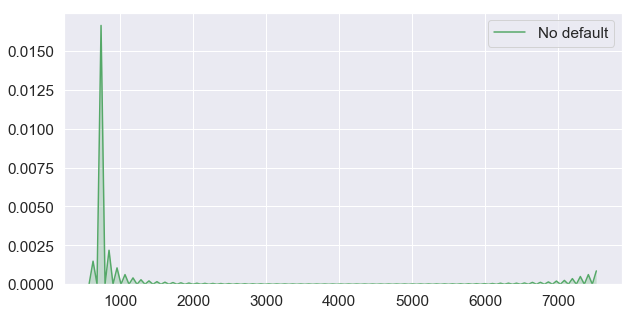

In [26]:
plt.figure(figsize=(10, 5))

sns.kdeplot(train['Credit Score'], shade=True, label='No default', color='g')
plt.show()

Данные содержат аномалнно высокие значения, возможно эта ошибка и в действительности рейтинг нужно понизить на разряд.
Проверим, будут ли совпадать распределения в случае, если большие значения понизим на разряд

In [29]:
low_credit_score = (train.loc[(train['Credit Score'] > 1000), 'Credit Score'] / 10).sample(200)
normal_credit_score = train.loc[(train['Credit Score'] < 1000), 'Credit Score'].sample(200)

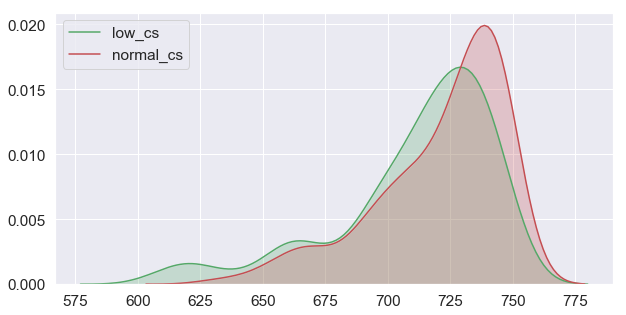

In [31]:
plt.figure(figsize=(10, 5))

sns.kdeplot(low_credit_score, shade=True, label='low_cs', color='g')
sns.kdeplot(normal_credit_score, shade=True, label='normal_cs', color='r')
plt.show()

* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости  α : 0.05
* Критическая область: двухсторонняя


Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений. Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, буде менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

In [33]:
print(shapiro(low_credit_score))
print(shapiro(normal_credit_score))

(0.8695328831672668, 4.2394442990867365e-12)
(0.8738152980804443, 7.219870968439013e-12)


По полученному значению p-value Шапиро-Уилка, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

Дополнительно воспользуемся критерием Манна-Уитни, который не требователен к закону распределения.

In [37]:
mannwhitneyu(low_credit_score, normal_credit_score)

MannwhitneyuResult(statistic=15769.0, pvalue=0.00012622393357481854)

Уровень значимости менбще 0.05, поэтому нулевая гипотеза так же отвергается в пользу альтернативной

Посомтрим на макс значения суммы кредита

In [331]:
train['Current Loan Amount'].max()

99999999.0

In [46]:
train.loc[train['Current Loan Amount'] == train['Current Loan Amount'].max(), 'Current Loan Amount'].count()

870

## Подготовка датасетов

In [49]:
def fill_na(df, score_median, years_mode, income_median):
    df['Credit Score'].fillna(score_median, inplace=True)
    df['Years in current job'].fillna(years_mode, inplace=True)
    df['Bankruptcies'].fillna(0, inplace=True)    
    df['Annual Income'].fillna(income_median, inplace=True)
    
    return df

In [50]:
def change_year(job_year):
    match = re.match(r'<? ?\d+', job_year)[0]
    if match == '< 1':
        return 0
    else:
        return float(match)

In [51]:
def remove_outliers(df, accounts_median, loan_mean):
    
    df.loc[df['Home Ownership'] == 'Have Mortage', 'Home Ownership'] = 'Home Mortgage'
    df['Years in current job'] = df['Years in current job'].apply(lambda x: change_year(x))
    df.loc[df['Tax Liens'] > 3, 'Tax Liens'] = 0
    df.loc[df['Number of Open Accounts'] > 30, 'Number of Open Accounts'] = \
                                                               accounts_median
    df.loc[df['Number of Credit Problems'] > 3, 'Number of Credit Problems'] = 0
    df.loc[df['Bankruptcies'] > 2, 'Bankruptcies'] = 0 
    df.loc[df['Current Loan Amount'] == df['Current Loan Amount'].max(), 'Current Loan Amount'] = loan_median
    
    return df
   
   

In [52]:
def category_to_float(df, dummies_cols):
    for cat_colname in dummies_cols:
        df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
        df = df.drop(cat_colname, axis=1)
    return df

In [53]:
def normilize(df, numerical_cols, scaler=StandardScaler()):
    df_norm = df.copy()
    df_norm[numerical_cols] = scaler.fit_transform(df_norm[numerical_cols])

    return df_norm
    

признак "цель кредита" может содержать значения, которых нет в тестовых данных, поэтому мы не будем использовать признак, так ка не можем гарантировать, что все значения их тестовой выборки присутствуют в обучающей выборке

## Обучение модели

In [54]:
X = train.drop(['Credit Default', 'Purpose'], axis=1)
y = train['Credit Default']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [55]:
def prepare_data(df, df_quartiles, score_median, years_mode, income_median, accounts_median, loan_median,
                 numerical_cols, dummies_cols):
    df = fill_na(df, score_median, years_mode, income_median)
    df = remove_outliers(df, accounts_median, loan_median)    
    df = category_to_float(df, dummies_cols)
    df_norm = normilize(df, numerical_cols, scaler=StandardScaler())
    return df_norm

In [59]:
import catboost as catb

In [56]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [57]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [64]:
numerical_cols = ['Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Years in current job', 'Number of Open Accounts', 'Annual Income']
 
dummies_cols = ['Home Ownership', 'Term'] 

In [73]:
cv=KFold(n_splits=3, random_state=12, shuffle=True)

i = 0

f1_scores = []
for train_index, test_index in cv.split(X, y):    
    i += 1
    
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]
    
    score_median = X_train['Credit Score'].median()
    years_mode = X_train['Years in current job'].mode()[0]
    income_median = X_train['Annual Income'].median()
    accounts_median = X_train['Number of Open Accounts'].median()
    loan_median = X_train['Current Loan Amount'].median()

    X_test = X.loc[test_index]
    y_test = y.loc[test_index]
    
    X_train = prepare_data(X_train, train_quartiles, score_median, years_mode, income_median,accounts_median, loan_median,
                       numerical_cols, dummies_cols)
    X_test = prepare_data(X_test, train_quartiles, score_median, years_mode, income_median, accounts_median, loan_median, 
                      numerical_cols, dummies_cols)
    
    df_for_balancing = pd.concat([X_train, y_train], axis=1)
    df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
    X_train = df_balanced.drop(columns=TARGET_NAME)
    y_train = df_balanced[TARGET_NAME]
    
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
     learning_rate = 0.1,
     n_estimators=100,
     max_depth=3,
     scale_pos_weight=1.3,
     l2_leaf_reg=1.0,
     bagging_temperature=1)
    
    model_catb.fit(X_train, y_train)

    y_train_pred = model_catb.predict(X_train)
    y_test_pred = model_catb.predict(X_test)

    f1_scores.append(f1_score(y_test, y_test_pred))
    
    print(f'FOLD {i}\n')

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    print('\n=============================================================')
print('Средний F1 ', round(np.array(f1_scores).mean(), 2))

FOLD 1

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.73      0.74      3573
           1       0.67      0.71      0.69      2854

   micro avg       0.72      0.72      0.72      6427
   macro avg       0.72      0.72      0.72      6427
weighted avg       0.72      0.72      0.72      6427

TEST

              precision    recall  f1-score   support

           0       0.84      0.60      0.70      1814
           1       0.40      0.70      0.51       686

   micro avg       0.63      0.63      0.63      2500
   macro avg       0.62      0.65      0.60      2500
weighted avg       0.72      0.63      0.65      2500

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1092  722
1                209  477

FOLD 2

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.73      0.74      3595
           1       0.66      0.68      0.67      2810

   micro avg       0.71

In [74]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

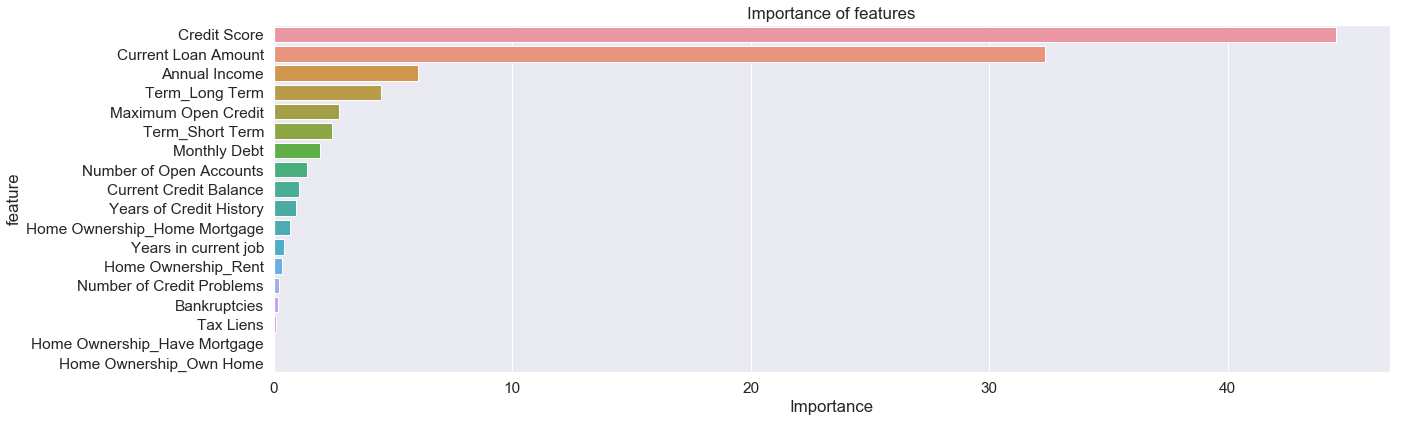

In [76]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)

In [77]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Annual Income',
 'Term_Long Term',
 'Maximum Open Credit',
 'Term_Short Term',
 'Monthly Debt',
 'Number of Open Accounts',
 'Current Credit Balance',
 'Years of Credit History',
 'Home Ownership_Home Mortgage',
 'Years in current job',
 'Home Ownership_Rent',
 'Number of Credit Problems',
 'Bankruptcies']

Финальная модель

In [78]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
     learning_rate = 0.1,
     n_estimators=100,
     max_depth=3,
     scale_pos_weight=1.3,
     l2_leaf_reg=1.0,
     bagging_temperature=1)
    
model_catb.fit(X_train[important_features_top], y_train)

y_train_pred = model_catb.predict(X_train[important_features_top])
y_test_pred = model_catb.predict(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.74      0.75      3606
           1       0.67      0.69      0.68      2788

   micro avg       0.72      0.72      0.72      6394
   macro avg       0.71      0.71      0.71      6394
weighted avg       0.72      0.72      0.72      6394

TEST

              precision    recall  f1-score   support

           0       0.85      0.65      0.74      1781
           1       0.45      0.71      0.55       719

   micro avg       0.67      0.67      0.67      2500
   macro avg       0.65      0.68      0.65      2500
weighted avg       0.73      0.67      0.68      2500

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1162  619
1                208  511


In [79]:
test = pd.read_csv('course_project_test.csv')
test = test.drop(['Months since last delinquent', 'Purpose'], axis=1)
test = prepare_data(test, train_quartiles, score_median, years_mode, income_median, accounts_median, loan_median,
                    numerical_cols, dummies_cols)

In [80]:
test['Credit Default'] = model_catb.predict(test[important_features_top])
test['Id'] = range(7500, 10000)

In [81]:
test[['Id', 'Credit Default']].head()

,Id,Credit Default
0,7500,1.0
1,7501,1.0
2,7502,1.0
3,7503,0.0
4,7504,0.0


In [82]:
test[['Id', 'Credit Default']].to_csv('loan_predictions.csv', index=False)